In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

from scipy import ndimage as ndi
import napari
import numpy as np
import cv2
import tifffile

from oiffile import OifFile
from confocal_3D.OifImageViewer import OifImageViewer

Using OpenCL device NVIDIA RTX A5000


In [2]:
path = "/home/dkermany/data/Bone_Project/oibs/FV10__20190620_111343.oib"

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660nm)



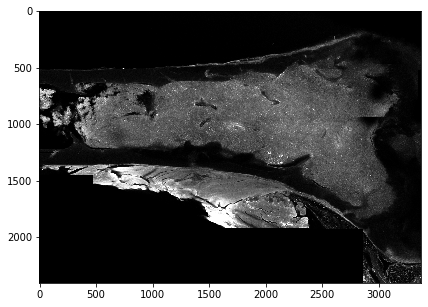

In [3]:
original_image = cle.push(viewer._arr[0])

plt.figure(figsize=(8,5))
cle.imshow(original_image[40])

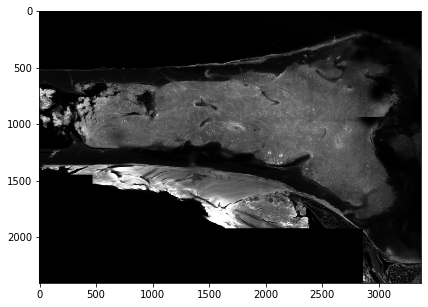

In [4]:
img_gaussian = cle.gaussian_blur(original_image, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(8,5))
cle.imshow(img_gaussian[40])

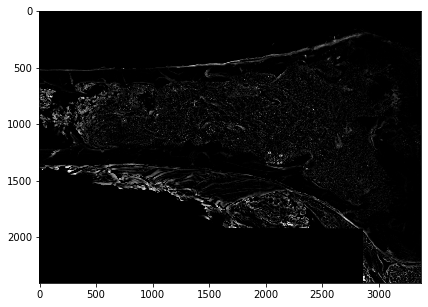

In [5]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(8,5))
cle.imshow(backgrund_subtracted[40])

In [6]:
# thicker_membranes = cle.maximum_sphere(backgrund_subtracted, radius_x=3, radius_y=3, radius_z=3)

# plt.figure(figsize=(8,5))
# cle.imshow(thicker_membranes[40])

In [7]:
# thresh1 = cle.threshold_otsu(thicker_membranes)

# plt.figure(figsize=(8,5))
# cle.imshow(thresh1[40])

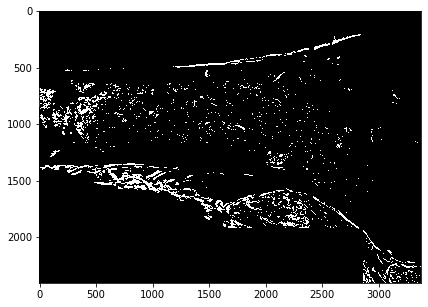

In [8]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(8,5))
cle.imshow(thresh2[40])

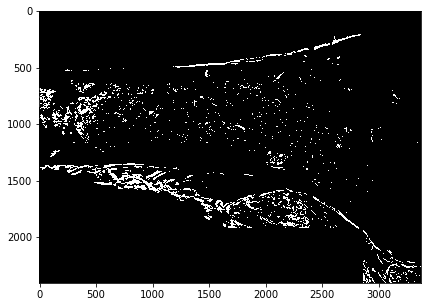

In [9]:
# Morphological openning
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(8,5))
cle.imshow(dilation[40])

In [10]:

dilation.shape

(76, 2404, 3376)

In [11]:
del erosion, backgrund_subtracted, img_gaussian, original_image

(76, 2404, 3376)


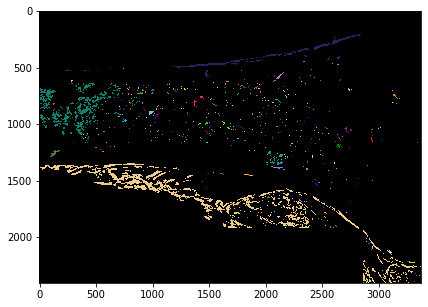

In [12]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(8,5))
cle.imshow(labels[40], labels=True)


In [14]:
cle.statistics_of_background_and_labelled_pixels(dilation, labels)

{'label': array([    1,     2,     3, ..., 10818, 10819, 10820]),
 'original_label': array([    0,     1,     2, ..., 10817, 10818, 10819]),
 'bbox_min_x': array([   0.,    0.,    0., ..., 3369., 3371., 3371.], dtype=float32),
 'bbox_min_y': array([   0.,  187.,  560., ..., 1140., 1054., 2384.], dtype=float32),
 'bbox_min_z': array([ 0.,  0., 27., ...,  0., 52.,  9.], dtype=float32),
 'bbox_max_x': array([3.375e+03, 2.852e+03, 1.000e+00, ..., 3.375e+03, 3.375e+03,
        3.373e+03], dtype=float32),
 'bbox_max_y': array([2403.,  645.,  562., ..., 1145., 1068., 2387.], dtype=float32),
 'bbox_max_z': array([75., 75., 30., ...,  8., 66., 12.], dtype=float32),
 'bbox_width': array([3.376e+03, 2.853e+03, 2.000e+00, ..., 7.000e+00, 5.000e+00,
        3.000e+00], dtype=float32),
 'bbox_height': array([2404.,  459.,    3., ...,    6.,   15.,    4.], dtype=float32),
 'bbox_depth': array([76., 76.,  4., ...,  9., 15.,  4.], dtype=float32),
 'min_intensity': array([0., 1., 1., ..., 1., 1., 1.], d

In [ ]:
labels = cle.erode_labels(labels, relabel_islands=True)
labels = cle.erode_labels(labels, relabel_islands=True)
plt.figure(figsize=(8,5))
cle.imshow(labels[40], labels=True)

In [ ]:
dil3d = cle.dilate_labels(labels)
plt.figure(figsize=(8,5))
cle.imshow(dil3d[40], labels=True)

In [32]:
del dilation, labels
smalls_filtered_out = cle.exclude_labels_outside_size_range(dil3d, None, 240, 6580)
plt.figure(figsize=(8,5))
cle.imshow(smalls_filtered_out[40], labels=True)

MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE

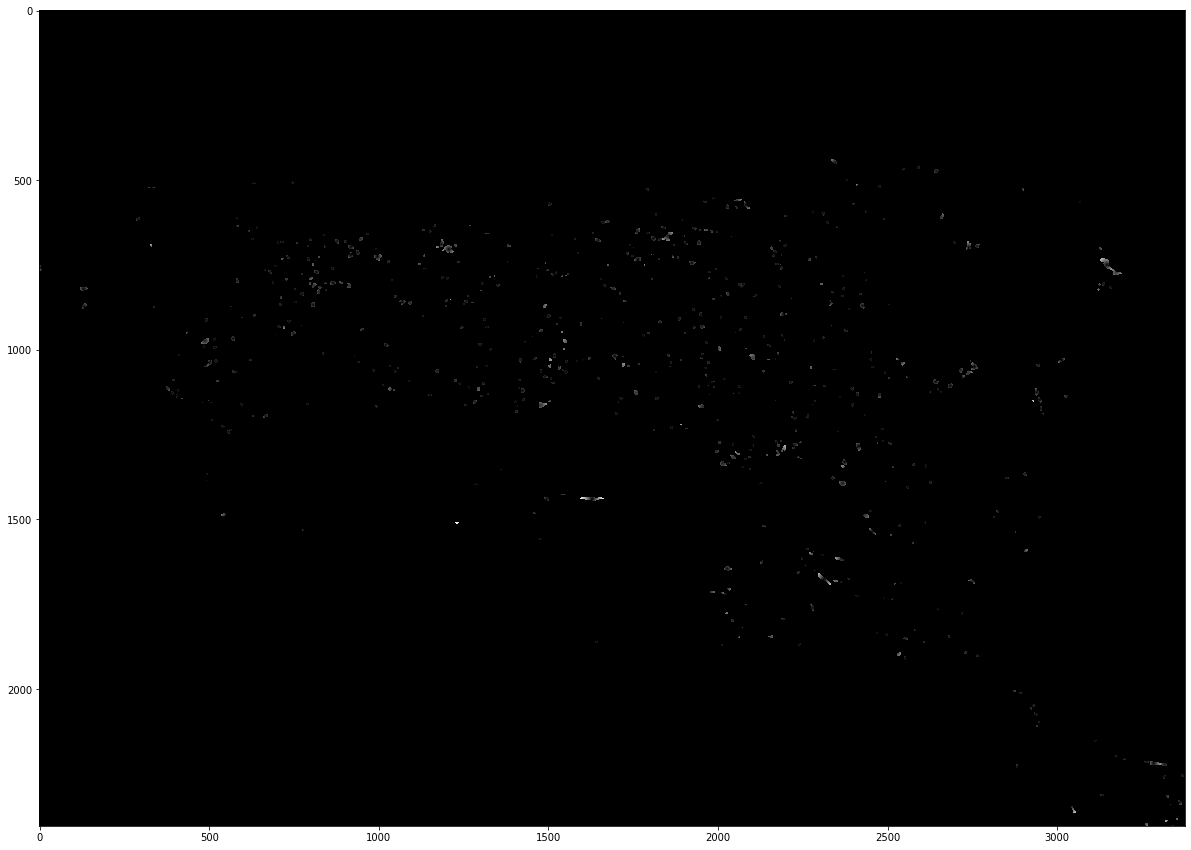

In [16]:
D = cle.euclidean_distance_from_label_centroid_map(smalls_filtered_out)
plt.figure(figsize=(8,5))
cle.imshow(D[40], labels=False)

size: 76


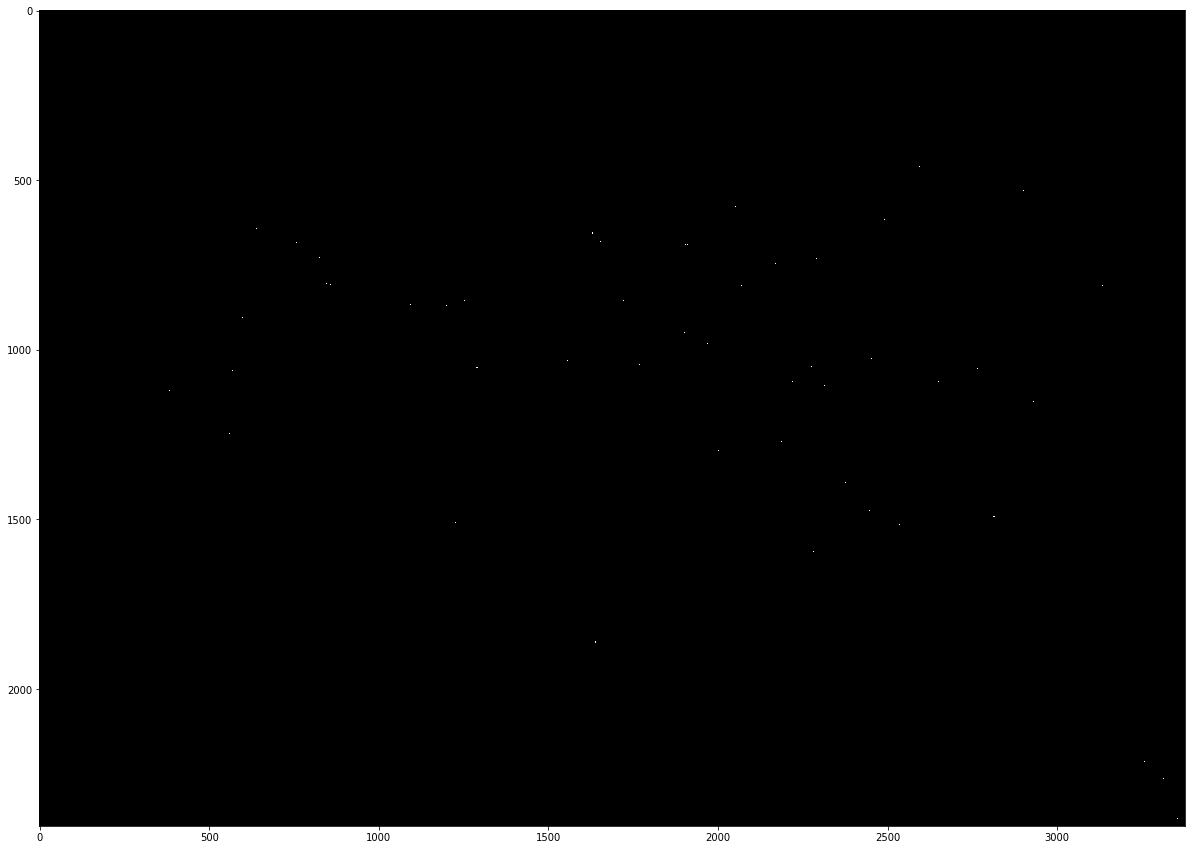

In [17]:
max_peaks = cle.detect_maxima_box(D)
plt.figure(figsize=(8,5))
cle.imshow(max_peaks[40], labels=False)

In [14]:
binarized = 3000 * (smalls_filtered_out > 0)

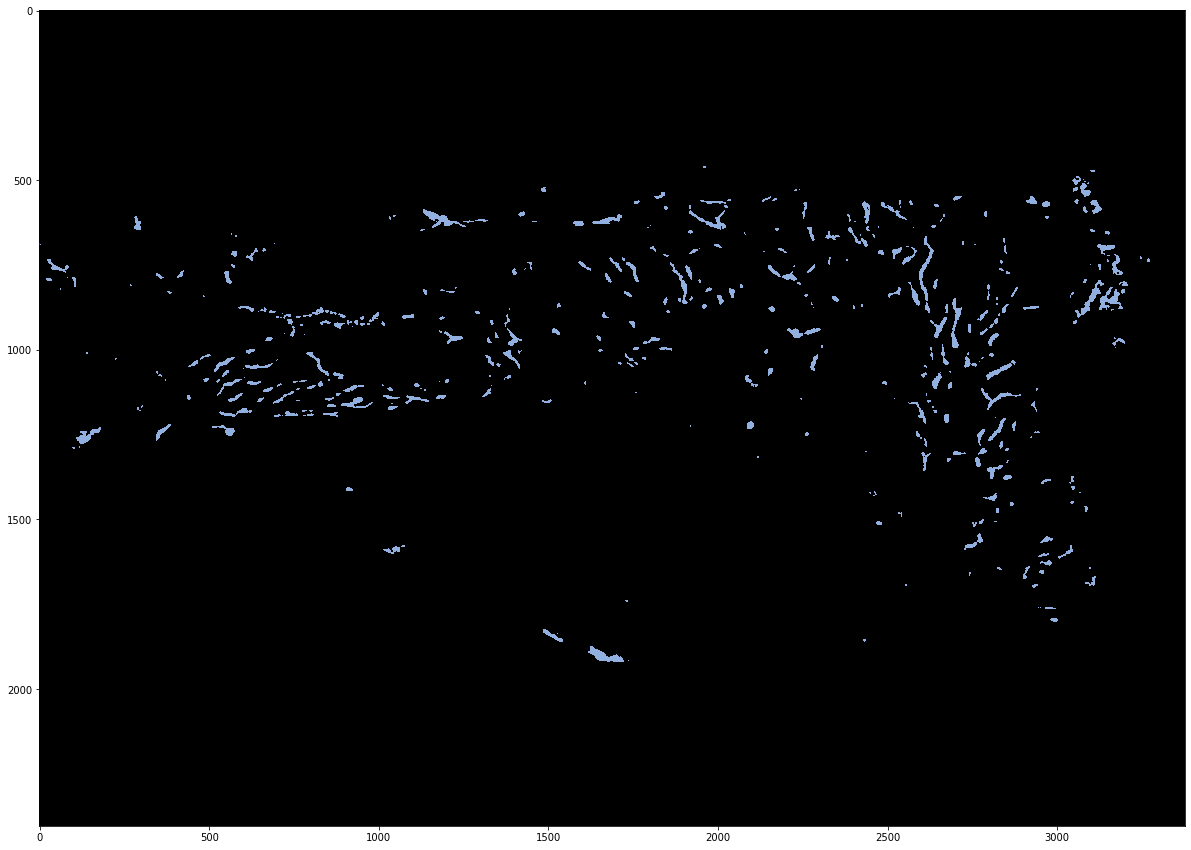

In [15]:
plt.figure(figsize=(8,5))
cle.imshow(binarized[40], labels=True)

In [16]:
image_with_segmentation = np.concatenate((viewer.arr, np.expand_dims(cle.pull(binarized), axis=0)), axis=0)
image_with_segmentation.shape

(4, 76, 2404, 3376)

In [17]:
viewer.save_as_tif_sequence(image_with_segmentation, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/NG2_segmentation/FV10__20190620_111343_NG2segmented")

In [18]:
np.unique(cle.pull(binarized))

array([   0, 3000], dtype=uint16)

In [19]:
image_with_segmentation.dtype

dtype('uint16')